In [ ]:
# gt.txtの説明
# 1:フレーム数(画像データのファイル名と対応)
# 2:物体番号
# 3:バウンディングボックスの左上のx座標
# 4:バウンディングボックスの左上のy座標
# 5:バウンディングボックスの幅
# 6:バウンディングボックスの高さ
# 7:Confidence score (0~1)
# 8:Class
# 9:Visibility 視認率。(0~1)

# 8のClassの説明
# Pedestrian 1
# Person on vehicle 2
# Car 3
# Bicycle 4
# Motorbike 5
# Non motorized vehicle 6
# Static person 7
# Distractor 8
# Occluder 9
# Occluder on the ground 10
# Occluder full 11
# Reflection 12

In [ ]:
# 連番画像の出力
import cv2
import numpy as np
import pandas as pd
import os

# テキストボックスの描画関数
# 画像, テキスト, 左下座標x, 左下座標y, テキストカラー, フォントサイズ, フォント太さ, ボックスカラー
def draw_textbox(img: np.ndarray,
                 text: str, x: int, y: int, text_color: tuple = (255, 255, 255), font_scale: float = 1, thickness: int = 2,
                 box_color: tuple = (255, 0, 0)) -> None:
    # テキストのサイズを取得, テキストのベースラインを取得(テキストの下端からベースラインまでの距離)
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    # バウンディングボックスの座標を計算
    top_left = (x, y - text_height)  # ボックス左上
    bottom_right = (x + text_width, y)  # ボックス右下
    # ボックスを描画(フチなし)
    cv2.rectangle(img, top_left, bottom_right, box_color, -1)
    # テキストを描画
    cv2.putText(img, text, (x, y), font, font_scale, text_color, thickness)

# 中心座標を求める関数
def calculate_center(x, y, w, h):
    return int((x * 2 + w) / 2.0), int((y * 2 + h) / 2.0)

# 画像の保存先フォルダ
upload_folder = 'img2\\'
# フォントの設定
font=cv2.FONT_HERSHEY_SIMPLEX
# gt.txtの読み込み, for文での読み込みよりも早い
df = pd.read_csv('intern_data\\MOT17-02-DPM\\gt\\gt.txt', sep = ',', encoding='cp932', header=None)
# フレームの数だけ繰り返す
for frame in range(1, 601):
    # ファイル名の作成
    filename = f'{frame:06}'
    input_filename = 'intern_data\\MOT17-02-DPM\\img1\\' + filename + '.jpg'
    upload_filename = upload_folder + filename + '.jpg'

    # input画像ファイルが存在するか確認
    if os.path.exists(input_filename):
        # 画像の読み込み
        img = cv2.imread(input_filename)
        # BGR→RGBに変換(順番入れ替え,OpenCVの仕様)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # frameのデータのみを抽出
        frame_line = df[df.iloc[:, 0] == frame]
        # 番号リスト (0～11)を(0～255)のunit8型配列に変換して1列に生成
        classlist = classlist = np.linspace(0, 255, 12).astype(np.uint8).reshape(-1, 1)
        # カラーマップを使用して色を生成 (COLORMAP_JETを使用)
        colormap = cv2.COLORMAP_JET
        # カラーマップを適用して3列に変換
        color_map = cv2.applyColorMap(classlist, colormap).reshape(-1, 3)

        # データの数(行数)だけ繰り返す
        for i in range(len(frame_line)):
            # 長方形の座標を取得
            recx, recy, recw, rech = frame_line.iloc[i, 2:6]
            # クラスを取得
            reccl = frame_line.iloc[i, 7]
            # 中心座標を求める
            reccx, reccy = calculate_center(recx, recy, recw, rech)
            # 座表の範囲画像内に収める
            reclx = int(max(0, recx))
            recly = int(max(0, recy))
            recrx = int(min(img.shape[1], recw + recx))
            recry = int(min(img.shape[0], rech + recy))
            # 描画色を求める
            color = tuple(map(int, color_map[reccl]))
            # 長方形の描画
            cv2.rectangle(img, (reclx, recly), (recrx, recry), color, thickness=3)
            # ラベル(Class)の描画
            draw_textbox(img, str(reccl), reclx, recly, text_color=(0,0,0), font_scale=0.5, thickness=2, box_color=color)
            # 重心の描画
            if(0 <= reccx < img.shape[1] and 0 <= reccy < img.shape[0]):
                cv2.drawMarker(img, (reccx, reccy), (0, 255, 0), markerSize=20)

        # フレーム以前のデータのみ抽出
        frame_line = df[df.iloc[:, 0] <= frame]
        # idの最大値を取得
        max_id = frame_line.iloc[:, 1].max()
        # 物体番号ごとに線を引く
        for i in range(1, max_id + 1):
            # 物体番号でフィルタリング
            frame_line_cl = frame_line[frame_line.iloc[:, 1] == i]
            # DataFrame が空の場合はスキップ
            if frame_line_cl.empty:
                continue
            # 最後の行がフレームに存在しない場合はスキップ
            if frame_line_cl.iloc[-1, 0] != frame:
                continue
            # データが2つ以上ない場合はスキップ
            if len(frame_line_cl) < 2:
                continue
            # 色を取得
            reccl = frame_line_cl.iloc[0, 7]
            color = tuple(map(int, color_map[reccl]))
            for j in range(len(frame_line_cl) - 1):
                # 長方形の座標を取得
                recx1, recy1, recw1, rech1 = frame_line_cl.iloc[j, 2:6]
                rectx2, recty2, recw2, rech2 = frame_line_cl.iloc[j + 1, 2:6]
                # 中心座標を求める
                reccx1, reccy1 = calculate_center(recx1, recy1, recw1, rech1)
                reccx2, reccy2 = calculate_center(rectx2, recty2, recw2, rech2)
                # 線の描画
                cv2.line(img, (reccx1, reccy1), (reccx2, reccy2), color, thickness = 1)
        
        # 画像の保存
        # BGR→RGBに変換(順番入れ替え,OpenCVの仕様)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(upload_filename, img)
    else:
        print(f"{input_filename} は存在しません。")
        break

In [13]:
import cv2
import os

image_folder = 'img'  # 画像フォルダのパス
output_video = 'movie\\output_video.mp4'  # 出力する動画ファイル名
fps = 30

# 画像ファイル名を取得し、ソートして存在確認
images = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()

# 最初の画像でフレームサイズを取得
frame = cv2.imread(images[0])
height, width, layers = frame.shape

# 動画ファイルの設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# 画像をフレームとして追加
for img_path in images:
    frame = cv2.imread(img_path)
    if frame is not None:
        video.write(frame)
    else:
        print(f"画像 {img_path} の読み込みに失敗しました。")

video.release()
print("動画の作成が完了しました。")


動画の作成が完了しました。


In [ ]:
# 20歩歩行のデータを抽出
import pandas as pd
# gt.txtの読み込み, for文での読み込みよりも早い
df = pd.read_csv('intern_data\\MOT17-02-DPM\\gt\\gt.txt', sep = ',', encoding='cp932', header=None)
result = np.empty((0, 2))  # 0行2列の空の配列
id_max = df.iloc[:, 1].max()
df_top_10 = df.groupby(1).head(20)
data_n = 0
for i in range(1, id_max + 1):
    df_id = df_top_10[df_top_10.iloc[:, 1] == i]
    if(df_id.shape[0] < 10):
        continue
    elif((df_id.iloc[:,7] == 1).all()):
        continue
    else:
        df_id_g = pd.DataFrame([df_id.iloc[:, 2] + df_id.iloc[:, 4] / 2,
                                df_id.iloc[:, 3] + df_id.iloc[:, 5] / 2]).T
        df_id_g = df_id_g.to_numpy()
        result = np.vstack([result, df_id_g])

# resultを.datファイルに保存
np.savetxt('intern_data\\MOT17-02-DPM\\10stepswalk\\10stepswalk.dat', result, delimiter=',', fmt='%.1f')



         0   1     2    3   4    5  6  7    8
0        1   1   912  484  97  109  0  7  1.0
1        2   1   912  484  97  109  0  7  1.0
2        3   1   912  484  97  109  0  7  1.0
3        4   1   912  484  97  109  0  7  1.0
4        5   1   912  484  97  109  0  7  1.0
...    ...  ..   ...  ...  ..  ... .. ..  ...
29998  593  80  1043  445  32   97  1  1  0.0
29999  594  80  1043  445  32   97  1  1  0.0
30000  600  81  1007  451  24   69  1  1  0.0
30001  600  82   987  473  21   43  1  1  0.0
30002  600  83   749  449  33   96  1  1  0.5

[1579 rows x 9 columns]


In [ ]:
# フレーム数の多い歩行者のデータを取得
import pandas as pd
# gt.txtの読み込み, for文での読み込みよりも早い
df = pd.read_csv('intern_data\\MOT17-02-DPM\\gt\\gt.txt', sep = ',', encoding='cp932', header=None)
df = df[df.iloc[:, 7] == 1]

group_sizes = df.groupby(1).size()

# 最も行数が多いグループを取得
most_frequent_n = group_sizes.idxmax()
# 最も行数が多いグループのデータを取得
df = df[df.iloc[:, 1] == most_frequent_n]
# x,y座標の中心を求める
df_g = pd.DataFrame([df.iloc[:, 2] + df.iloc[:, 4] / 2,
                                df.iloc[:, 3] + df.iloc[:, 5] / 2]).T
df_g = df_g.to_numpy()

# most_frequent_group_dataを.datファイルに保存
np.savetxt('intern_data\\MOT17-02-DPM\\seriesdata\\seriesdata.dat', df_g, delimiter=',', fmt='%.1f')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from io import StringIO
import matplotlib.font_manager as fm

# サンプルデータの生成 (時系列データ)

data = np.loadtxt('intern_data\\MOT17-02-DPM\\10stepswalk\\10stepswalk.dat', delimiter=',')

# ウィンドウサイズを設定
window_size = 10
# データの列数を取得
n_samples = data.shape[0]
print(n_samples)

# 入力データとラベルを作成
X, Y = [], []
for i in range(0, n_samples, window_size):
    X.append(data[i:i + window_size-1])  # 過去の座標
    Y.append(data[i + window_size-1])   # 次の座標
X = np.array(X)
Y = np.array(Y)

# データのスケーリング
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)  # Xのスケーリング
Y = scaler.fit_transform(Y)  # Yのスケーリング

# データの分割
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# LSTMモデルの構築
model = Sequential([
    LSTM(50, input_shape=(window_size, 2), return_sequences=False),
    Dense(2)  # 次のx, y座標を出力
])

# モデルのコンパイルとトレーニング
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test))

# 予測
predicted = model.predict(X_test)
# 予測結果を元のスケールに戻す
predicted = scaler.inverse_transform(predicted)
# 実際の値も逆スケーリング
Y_test_actual = scaler.inverse_transform(Y_test)

# グラフの作成
# 日本語フォントを指定 (IPAexGothicを使用)
plt.rcParams['font.family'] = 'Meiryo'
# 図の作成とサイズ指定
plt.figure(figsize=(5, 5))  # 幅8インチ、高さ8インチ
# 散布図を描画
plt.scatter(Y_test_actual, predicted, color='red',s = 5)
# 内向きの目盛りを設定
plt.tick_params(direction='in', which='both')  # 'both' でx軸とy軸両方の目盛りを内向きに

plt.xlabel(r'テストデータ',fontsize=15)
plt.ylabel('予測データ',fontsize=15)
plt.legend()             # 凡例を表示
# plt.xlim(min(x1), max(x1)/2) # X軸の範囲を調整
# plt.ylim(0, max(y)+0.5)  # Y軸の範囲を調整
# グラフを画像として保存 (PNG形式)
plt.savefig('graph/predicted.png', bbox_inches='tight')
plt.show()

# 結果の表示
print("Actual:", Y_test_actual[0])
print("Predicted:", predicted[0])
# モデル評価
mse = mean_squared_error(Y_test_actual, predicted)
print("Mean Squared Error:", mse)


420
Epoch 1/20


c:\Users\SASAKILAB24\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.4530 - val_loss: 0.3657
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3532 - val_loss: 0.2729
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2612 - val_loss: 0.1927
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1945 - val_loss: 0.1245
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1303 - val_loss: 0.0685
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0884 - val_loss: 0.0299
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0478 - val_loss: 0.0154
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0440 - val_loss: 0.0192
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0402 - val_loss: 0.0213
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0464 - val_loss: 0.0158
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0342 - val_loss: 0.0090
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0235 - val_loss: 0.0057
Epoch 13/20

600


c:\Users\SASAKILAB24\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.1552 - val_loss: 0.1238
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084 - val_loss: 0.0046
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7133e-04 - val_loss: 0.0015
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0479e-04 - val_loss: 0.0016
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1840e-05 - val_loss: 0.0017
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.2589e-05 - val_loss: 0.0017
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.3410e-05 - val_loss: 0.0020
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.3092e-05 - val_loss: 0.0018
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5845e-05 - val_loss: 0.0018
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.6292e-05 - val_loss: 0.0020
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1073e-05 - val_loss: 0.0024
Epoch 12/20
30/30 ━━━━━━━━

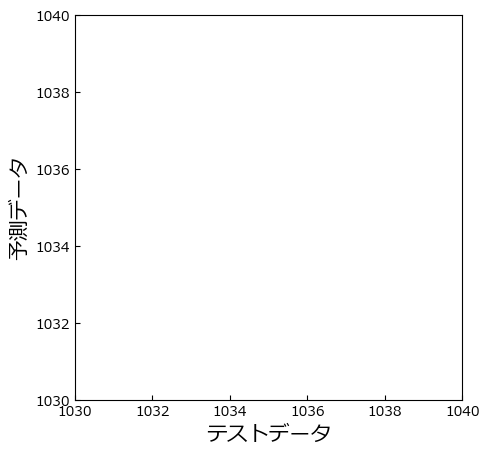

Mean Squared Error: 6.084563708122236


In [ ]:
# LSTM(長期記憶が得意なRNN)による歩行者データの予測
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from io import StringIO
import matplotlib.font_manager as fm

# サンプルデータの生成 (時系列データ)
data = np.loadtxt('intern_data\\MOT17-02-DPM\\seriesdata\\seriesdata.dat', delimiter=',')
# ウィンドウサイズを設定
window_size = 10
# データの列数を取得
n_samples = data.shape[0]

# 入力データとラベルを作成(1づつずらす)
X, Y = [], []
for i in range(0, n_samples - window_size):
    X.append(data[i:i + window_size, :])  # 過去のデータ
    Y.append(data[i + window_size, :])   # 次の座標
X = np.array(X)
Y = np.array(Y)

# 入力データと出力データを連結してスケーリング
combined = np.vstack([X.reshape(-1, X.shape[2]), Y])
scaler = MinMaxScaler(feature_range=(0, 1))
combined_scaled = scaler.fit_transform(combined)

# スケーリング後に分割
X = combined_scaled[:len(X.reshape(-1, X.shape[2]))].reshape(X.shape)
Y = combined_scaled[len(X.reshape(-1, X.shape[2])):]

# データの分割
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# LSTMモデルの構築
model = Sequential([
    LSTM(50, input_shape=(window_size, 2), return_sequences=False), # 隠れ層(ユニット数50)
    Dense(2)  # 次のx, y座標を出力(全結合層)
])

# モデルのコンパイルとトレーニング
# 最適化アルゴリズム: Adam, 損失関数: 平均二乗誤差
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test))

# 予測
predicted = model.predict(X_test)
print(predicted.shape)
print(X.shape)
# 予測結果を元のスケールに戻す
predicted = scaler.inverse_transform(predicted)
# 実際の値も逆スケーリング
Y_test_actual = scaler.inverse_transform(Y_test)

# グラフの作成---------------------------------------------------------------------------
# 日本語フォントを指定 (IPAexGothicを使用)
plt.rcParams['font.family'] = 'Meiryo'
# 図の作成とサイズ指定
plt.figure(figsize=(5, 5))  # 幅8インチ、高さ8インチ
# 散布図を描画
plt.scatter(Y_test_actual[:, 0], predicted[:, 0], color='red',s = 5)
# 内向きの目盛りを設定
plt.tick_params(direction='in', which='both')  # 'both' でx軸とy軸両方の目盛りを内向きに
plt.xlabel(r'テストデータx',fontsize=15)
plt.ylabel('予測データx',fontsize=15)
plt.xlim(1130, 1140) # X軸の範囲を調整
plt.ylim(1130, 1140)  # Y軸の範囲を調整
# グラフを画像として保存 (PNG形式)
plt.savefig('graph/predicted_x.png', bbox_inches='tight')
plt.show()
# 図の作成とサイズ指定
plt.figure(figsize=(5, 5))  # 幅8インチ、高さ8インチ
# 散布図を描画
plt.scatter(Y_test_actual[:, 1], predicted[:, 1], color='red',s = 5)
# 内向きの目盛りを設定
plt.tick_params(direction='in', which='both')  # 'both' でx軸とy軸両方の目盛りを内向きに
plt.xlabel(r'テストデータy',fontsize=15)
plt.ylabel('予測データy',fontsize=15)
plt.xlim(500, 514) # X軸の範囲を調整
plt.ylim(500, 514)  # Y軸の範囲を調整
# グラフを画像として保存 (PNG形式)
plt.savefig('graph/predicted_y.png', bbox_inches='tight')
plt.show()

# ---------------------------------------------------------------------------

# モデル評価
mse = mean_squared_error(Y_test_actual, predicted)
print("Mean Squared Error:", mse)

# 予測結果を.datファイルに保存
i = split + window_size + 1
with open('intern_data\\MOT17-02-DPM\\seriesdata\\predicted_x.dat', 'w') as f:
    for prex,prey in predicted:
        f.write(f'{i},{prex:.1f},{prey:.1f}\n')
        i += 1